In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import plotly.express   as px
import cv2
import warnings
import plotly.graph_objects as go
from joblib import dump


In [26]:
warnings.simplefilter('ignore')

#### Get car and motor resolutions to decide on a window size that will be used for extracting hog features

In [3]:
car_resolutions = []
for dirname, _,filenames in os.walk('car'):
        for file_n in filenames:
                # Load the image file using OpenCV
                img_path = os.path.join("car", file_n)
                img = cv2.imread(img_path)              
                # Extract the size of the image
                resolution = img.shape[:2]
                car_resolutions.append(resolution)

car_resolutions_np = np.array(car_resolutions)

In [4]:
motor_resolutions = []
for dirname, _,filenames in os.walk('motor'):
    for file_n in filenames:
        # Load the image file using OpenCV
        img_path = os.path.join("motor", file_n)
        img = cv2.imread(img_path)
        # Extract the size of the image
        resolution = img.shape[:2]
        motor_resolutions.append(resolution)

motor_resolutions_np = np.array(motor_resolutions)

In [5]:
print("avg CAR resolution: ",np.average(car_resolutions_np[:, 0]),np.average(car_resolutions_np[:, 1]))
print("avg MOTOR resolution: ",np.average(motor_resolutions_np[:, 0]),np.average(motor_resolutions_np[:, 1]))



avg CAR resolution:  28.68068669527897 42.9480686695279
avg MOTOR resolution:  28.416075650118202 24.192858031603834


#### Example resizing


In [12]:
img_path = os.path.join("motor", "1_cropped_19.png")
ornek_goruntu = cv2.imread(img_path)              
print("orijinal boyut: ",ornek_goruntu.shape[:2])
yeniden_boyutlandirilmis_goruntu = cv2.resize(ornek_goruntu, (43,28), interpolation=cv2.INTER_LINEAR)
print("resized boyut: ",yeniden_boyutlandirilmis_goruntu.shape[:2])


orijinal boyut:  (28, 26)
resized boyut:  (28, 43)


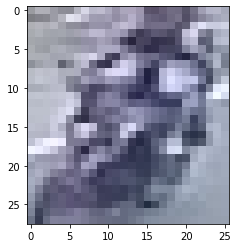

In [13]:
plt.imshow(cv2.cvtColor(ornek_goruntu, cv2.COLOR_BGR2RGB))

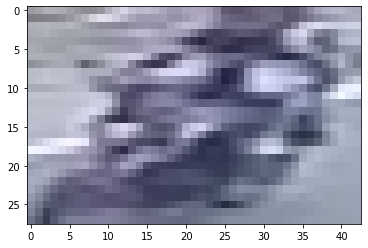

In [14]:
plt.imshow(cv2.cvtColor(yeniden_boyutlandirilmis_goruntu, cv2.COLOR_BGR2RGB))

### Extract HOG features and labels for all images in the train set.


In [7]:
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.neural_network import MLPClassifier


In [15]:
# Directory paths for car and motorcycle images
araba_klasoru = "car"
motor_klasoru = "motor"
non_vehicle_klasörü = "none"

# Lists to store HOG features and labels
features = []
labels = []

In [16]:
# Extract HOG features and labels for car images

for file_n in os.listdir(araba_klasoru):
    img = cv2.imread(os.path.join(araba_klasoru, file_n))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resclaed_img = cv2.resize(gray, (40,30 ), interpolation=cv2.INTER_LINEAR)
    hog_features = hog(resclaed_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
    features.append(hog_features)
    labels.append(0)   # Label for car: 0


In [17]:
# Extract HOG features and labels for motorcycle images
for file_n in os.listdir(motor_klasoru):

    img = cv2.imread(os.path.join(motor_klasoru, file_n))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resclaed_img = cv2.resize(gray, (40,30 ), interpolation=cv2.INTER_LINEAR)
    hog_features = hog(resclaed_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
    features.append(hog_features)
    labels.append(1)   # Label for motorcycle: 1


In [18]:
# Extract HOG features and labels for non-vehicle images
for file_n in os.listdir(non_vehicle_klasörü):
    if file_n != ".DS_Store":
        img = cv2.imread(os.path.join(non_vehicle_klasörü, file_n))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resclaed_img = cv2.resize(gray, (40,30), interpolation=cv2.INTER_LINEAR)
        hog_features = hog(resclaed_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
        features.append(hog_features)
        labels.append(2)  # Label for non-vehicle: 2

In [21]:
X = np.array(features)
y = np.array(labels)

### Train 3 Different Machine Learning Classifier

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import KFold


#### SVM CLASSIFIER

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html 

In [22]:


# define SVM model
svm_model = SVC(kernel='linear')

# cross_val_predict fonksiyonunu kullanarak K-fold çapraz doğrulama yapma
# Bu fonksiyon, tahminleri döndürür, ancak gerçek değerlerle karşılaştırmak için kullanılır
y_pred = cross_val_predict(svm_model, X, y, cv=5)

# Confusion matrix hesaplama
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(cm)

# Doğruluk (accuracy) hesaplama
accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)


Confusion Matrix:
[[11098   261   291]
 [  270  7384   383]
 [  211   219 35570]]
Accuracy: 0.9706394670210282


with linear kernel

In [24]:

k_folds = 5
kf = KFold(n_splits=k_folds)
a=1
svm_classifiers = []
svm_accuracies = []

for train_index, val_index in kf.split(X):
    X_train, X_test = X[train_index], X[val_index]
    y_train, y_test = y[train_index], y[val_index]
    
    svm_classifier = SVC(kernel='linear')
    svm_classifier.fit(X_train, y_train)

    svm_classifiers.append(svm_classifier)

    # Eğitim veri seti üzerinde modelin doğruluğunu değerlendirin
    train_accuracy = svm_classifier.score(X_train, y_train)
    print("k-fold "+str(a) )
    print("Eğitim doğruluğu:", train_accuracy)

    # Geçerleme veri seti üzerinde modelin doğruluğunu değerlendirin
    val_accuracy = svm_classifier.score(X_test, y_test)
    print("Geçerleme doğruluğu:", val_accuracy)

    svm_accuracies.append(val_accuracy)  
    a+= 1

best_svm_model_index = np.argmax(svm_accuracies)
best_svm_model = svm_classifiers[best_svm_model_index]



dump(best_svm_model, 'svm_model.joblib')

k-fold 1
Eğitim doğruluğu: 0.9830523693012189
Geçerleme doğruluğu: 0.7983479978452146
k-fold 2
Eğitim doğruluğu: 0.988776403510741
Geçerleme doğruluğu: 0.2748249236846831
k-fold 3
Eğitim doğruluğu: 0.9699663299663299
Geçerleme doğruluğu: 0.9841070306186586
k-fold 4
Eğitim doğruluğu: 0.97003367003367
Geçerleme doğruluğu: 0.9850947292807758
k-fold 5
Eğitim doğruluğu: 0.9705274971941639
Geçerleme doğruluğu: 0.9832989135314717


['svm_model.joblib']

with rbf (radial basis function)  kernel

In [33]:

k_folds = 5
kf = KFold(n_splits=k_folds)
a=1
svm_classifiers2 = []
svm_accuracies2 = []

for train_index, val_index in kf.split(X):
    X_train, X_test = X[train_index], X[val_index]
    y_train, y_test = y[train_index], y[val_index]
    
    svm_classifier = SVC()
    svm_classifier.fit(X_train, y_train)

    svm_classifiers2.append(svm_classifier)

    # Eğitim veri seti üzerinde modelin doğruluğunu değerlendirin
    train_accuracy2 = svm_classifier.score(X_train, y_train)
    print("k-fold "+str(a) )
    print("Eğitim doğruluğu:", train_accuracy2)

    # Geçerleme veri seti üzerinde modelin doğruluğunu değerlendirin
    val_accuracy = svm_classifier.score(X_test, y_test)
    print("Geçerleme doğruluğu:", val_accuracy)

    svm_accuracies2.append(val_accuracy)  
    a+= 1

best_svm_model_index2 = np.argmax(svm_accuracies2)
best_svm_model2 = svm_classifiers2[best_svm_model_index2]



dump(best_svm_model2, 'svm_model2.joblib')

k-fold 1
Eğitim doğruluğu: 0.9984735908774608
Geçerleme doğruluğu: 0.8802298437780571
k-fold 2
Eğitim doğruluğu: 0.9994837145614941
Geçerleme doğruluğu: 0.2781468845394146
k-fold 3
Eğitim doğruluğu: 0.9981144781144781
Geçerleme doğruluğu: 0.9965879500763222
k-fold 4
Eğitim doğruluğu: 0.9980695847362514
Geçerleme doğruluğu: 0.9977552303133699
k-fold 5
Eğitim doğruluğu: 0.9980695847362514
Geçerleme doğruluğu: 0.9968573224387178


['svm_model2.joblib']

#### XGBOOST CLASSIFIER

https://xgboost.readthedocs.io/en/stable/python/python_api.html 

In [34]:


k_folds = 5
kf = KFold(n_splits=k_folds)
a=1
xgb_classifiers = []
xgb_accuracies = []

for train_index, test_index in kf.split(X):    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    xgb_classifier = xgb.XGBClassifier()
    xgb_classifier.fit(X_train, y_train)

    xgb_classifiers.append(xgb_classifier)

    # Eğitim veri seti üzerinde modelin doğruluğunu değerlendirme
    train_pred = xgb_classifier.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    print("k-fold "+str(a) )
    print("Eğitim doğruluğu:", train_accuracy)
    a+= 1
    
    # Geçerleme veri seti üzerinde modelin doğruluğunu değerlendirme
    val_pred = xgb_classifier.predict(X_test)
    val_accuracy = accuracy_score(y_test, val_pred)
    print("Geçerleme doğruluğu:", val_accuracy)

    xgb_accuracies.append(val_accuracy)  


best_xgb_model_index = np.argmax(xgb_accuracies)
best_xgb_model = xgb_classifiers[best_xgb_model_index]

dump(best_xgb_model, 'xgb_model.joblib')

[23:38:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
k-fold 1
Eğitim doğruluğu: 1.0
Geçerleme doğruluğu: 0.7590231639432573
[23:40:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
k-fold 2
Eğitim doğruluğu: 1.0
Geçerleme doğruluğu: 0.27751840545878975
[23:41:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/l

['xgb_model.joblib']

#### MLP CLASSIFIER

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [31]:
k_folds = 5
kf = KFold(n_splits=k_folds)
a=1

mlp_classifiers = []
mlp_accuracies = []

for train_index, test_index in kf.split(X):  
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)
    mlp_classifier.fit(X_train, y_train)

    mlp_classifiers.append(mlp_classifier)

    # Eğitim veri seti üzerinde modelin doğruluğunu değerlendirme
    train_pred = mlp_classifier.predict(X_train)

    train_accuracy = accuracy_score(y_train, train_pred)
    print("k-fold "+str(a) )
    print("Eğitim doğruluğu:", train_accuracy)
    a+= 1

    # Geçerleme veri seti üzerinde modelin doğruluğunu değerlendirme
    val_pred = mlp_classifier.predict(X_test)
    val_accuracy = accuracy_score(y_test, val_pred)
    print("Geçerleme doğruluğu:", val_accuracy)

    mlp_accuracies.append(val_accuracy)  


best_mlp_model_index = np.argmax(mlp_accuracies)
best_mlp_model = mlp_classifiers[best_mlp_model_index]

best_mlp_model

dump(best_mlp_model, 'mlp_model.joblib')

k-fold 1
Eğitim doğruluğu: 1.0
Geçerleme doğruluğu: 0.8876818100197522
k-fold 2
Eğitim doğruluğu: 1.0
Geçerleme doğruluğu: 0.27760818818459326
k-fold 3
Eğitim doğruluğu: 1.0
Geçerleme doğruluğu: 0.9948819251144833
k-fold 4
Eğitim doğruluğu: 1.0
Geçerleme doğruluğu: 0.9961389961389961
k-fold 5
Eğitim doğruluğu: 0.9933782267115601
Geçerleme doğruluğu: 0.9842866121935889


['mlp_model.joblib']